Earlystopping Patience Counter: 1
Earlystopping Patience Counter: 1
Earlystopping Patience Counter: 2
Earlystopping Patience Counter: 1
Earlystopping Patience Counter: 1
Earlystopping Patience Counter: 1
Earlystopping Patience Counter: 1
Earlystopping Patience Counter: 1
Earlystopping Patience Counter: 1
Earlystopping Patience Counter: 1
Earlystopping Patience Counter: 1
Earlystopping Patience Counter: 1
Earlystopping Patience Counter: 1
Earlystopping Patience Counter: 2
Earlystopping Patience Counter: 3
Earlystopping Patience Counter: 1
Earlystopping Patience Counter: 2
Earlystopping Patience Counter: 3
Earlystopping Patience Counter: 4
Earlystopping Patience Counter: 5


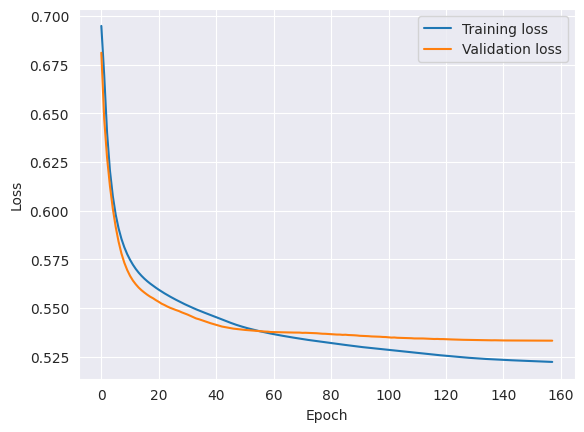

Finished Training in: 21.16744613647461 second.


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from time import time 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

train_df = pd.read_csv('cure_the_princess_train.csv').to_numpy()
test_df = pd.read_csv('cure_the_princess_test.csv').to_numpy()
validation_df = pd.read_csv('cure_the_princess_validation.csv').to_numpy()

train_features = train_df[:,:-1]
validation_features = validation_df[:,:-1]
test_features = test_df[:,:-1]
train_targets = train_df[:,-1]
validation_targets = validation_df[:,-1]
test_targets = test_df[:,-1]

learning_rate = 0.01
num_epochs = 300
patience = 5
BATCH_SIZE = 16
torch.manual_seed(190401101)



class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        # Ağırlıklar çarpılıp biaslar eklenip fonksiyonlar tanımlandı
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    #Aktivasyon fonksiyonları eklendi
    #Hidden  layer’larda  ReLU,  output layer’da sigmoid aktivasyonu var
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, index):
        return torch.tensor(self.features[index]), torch.tensor(self.targets[index])


train_dataset = CustomDataset(train_features, train_targets)
validation_dataset = CustomDataset(validation_features, validation_targets)
test_dataset = CustomDataset(test_features, test_targets)
trainloader = DataLoader(train_dataset, batch_size = BATCH_SIZE) 
valloader = DataLoader(validation_dataset, batch_size = BATCH_SIZE) 
testloader = DataLoader(test_dataset, batch_size = BATCH_SIZE) 

input_sizee = train_features.shape[1]
hidden_sizee1 = 100
hidden_sizee2 = 50
output_sizee = 1
model = MLP(input_sizee, hidden_sizee1, hidden_sizee2, output_sizee)

l1_lambda = 0.001
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l1_lambda)



this_moment = time()
list_train_loss, list_val_loss = [], []

best_val_loss = None

patience_counter = 0
# Train the model
for epoch in range(num_epochs):

    # training loop
    train_loss = 0.0
    train_count = 0.0
    for inputs, labels in trainloader:
        inputs = inputs.to(torch.float32)
        labels = labels.to(torch.float32)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_count += 1.0
        train_loss += loss.item()

    val_loss = 0.0

    with torch.no_grad():
        model.eval()
        for inputs, labels in valloader:
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)          
            outputs = model(inputs)
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels)
            #validation_count += 1.0
            val_loss += loss.item()

    model.train()

    # calculate metrics
    train_loss /= train_count
    val_loss /= len(valloader)
    

   

    list_train_loss.append(train_loss)
    list_val_loss.append(val_loss)

    val_score = val_loss
    if best_val_loss is None:
        best_val_loss = val_score # hafızada patience boyu tutmaya başla
        torch.save(model.state_dict(), "checkpoint.pt")
    elif best_val_loss < val_score: # patience counter
        patience_counter += 1
        print("Earlystopping Patience Counter:",patience_counter)
        if patience_counter == patience:
            break
    else:
        best_val_loss = val_score
        torch.save(model.state_dict(), "checkpoint.pt") # to keep the best model
        patience_counter = 0
    



# plot the results
sns.set_style("darkgrid")
plt.plot(list_train_loss, label="Training loss")
plt.plot(list_val_loss, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

print('Finished Training in: ' + str(time() - this_moment) + ' second.' )

In [4]:
model.load_state_dict(torch.load('checkpoint.pt'))
model.eval()
predicts =[]
real_labels = list()
with torch.no_grad():
    for inputs,label in testloader:
        inputs = inputs.to(torch.float32)
        labels = labels.to(torch.float32)          
        outputs = model(inputs)
        _,predict = torch.max(outputs.data,1)
        predicts.extend(predict.tolist())
        real_labels.extend(label.tolist())


from sklearn.metrics import f1_score,accuracy_score,classification_report
print("Accuracy score of this model: {}".format(accuracy_score(real_labels,predicts)))
print(classification_report(real_labels,predicts))

Accuracy score of this model: 0.49740932642487046
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.66       384
         1.0       0.00      0.00      0.00       388

    accuracy                           0.50       772
   macro avg       0.25      0.50      0.33       772
weighted avg       0.25      0.50      0.33       772

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [5]:
from sklearn.metrics import f1_score, precision_score, recall_score

model.eval()

true_labels = []
pred_labels = []
correct = 0.0
total = 0.0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(torch.float32)
        labels = labels.to(torch.float32)
        outputs = model(inputs)
        outputs = outputs.squeeze()
        predicted = torch.round(outputs)
        true_labels.extend(labels.tolist())
        pred_labels.extend(predicted.tolist())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * (correct / total)
f1 = f1_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)

print("Test Accuracy: {:.2f}%".format(accuracy))
print("F1 score: {:.4f}".format(f1))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))


Test Accuracy: 94.30%
F1 score: 0.9410
Precision: 0.9804
Recall: 0.9046


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=142e59b3-5bec-445f-8785-46815f8d8958' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>